# g_recsys_gnn_v2 — LightGCN Upgrade
- v1 문제 요약: Recall/coverage 정체(Recall@10≈0.09, coverage<1%), 일부 인기 영화만 계속 추천
- 개선 목표: 롱테일 사용자/아이템 노출 확대, hard negative 강화, 조기 수렴 방지
- 주요 업그레이드 (docs/claude_v2_gnn.md & gpt_v2.md 기반)
  1. **Label threshold 3.5**: positive pool 확장해 그래프 커버리지 확보
  2. **Tail-aware sampling**: item 빈도^(-0.5) 가중치로 롱테일을 자주 학습
  3. **Hard negative mix**: 인기 아이템 중 일부를 의도적으로 음수 샘플로 사용하여 구분 능력 강화
  4. **Early stopping + best checkpoint**: Recall@20 기준으로 저장 → overfitting 방지
  5. **Embedding 정규화**: diversity 확보 및 over-smoothing 완화


## 실험 로드맵
1. 데이터 분석 및 매핑 (README 0번)
2. 사용자별 stratified split + tail-aware positive sampler 구축
3. LightGCN (embedding=64, layer=3) + hard negative BPR 학습 루프
4. Early stopping / 체크포인트 / metric 추적
5. Validation 기반 threshold 튜닝 + O/X 출력 (README 요구 포맷)
6. 추가 breakthrough 아이디어 기록


In [1]:

import os
from pathlib import Path
import json
import math
import random
import copy
from collections import defaultdict
from typing import Dict, List

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [2]:

DATA_PATH = Path('data/train.csv')
OUTPUT_DIR = Path('artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

RATING_POS_THRESHOLD = 4
VAL_RATIO = 0.10
TEST_RATIO = 0.10
NEGATIVE_SAMPLE_RATIO = 8
HARD_NEG_RATIO = 0.35
TAIL_TEMPERATURE = 0.5  # item freq^(-temperature)
EMBED_DIM = 64
NUM_LAYERS = 3
LR = 8e-4
WEIGHT_DECAY = 5e-5
EMBED_REG = 1e-4
BATCH_SIZE = 4096
EPOCHS = 80
EVAL_EVERY = 5
PATIENCE = 6
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


Device: cpu


In [3]:

ratings_df = pd.read_csv(DATA_PATH)
ratings_df['label'] = (ratings_df['rating'] >= RATING_POS_THRESHOLD).astype(np.int64)

print('Dataset stats:')
print(ratings_df.describe())
print('Label ratio (>= {:.1f})'.format(RATING_POS_THRESHOLD))
print(ratings_df['label'].value_counts(normalize=True))

user_counts = ratings_df.groupby('user')['item'].count()
item_counts = ratings_df.groupby('item')['user'].count()
print('User degree stats:')
print(user_counts.describe())
print('Item degree stats:')
print(item_counts.describe())


Dataset stats:
                user           item         rating          label
count  105139.000000  105139.000000  105139.000000  105139.000000
mean      365.067178   13388.249841       3.517049       0.492966
std       197.388251   26178.083791       1.044640       0.499953
min         1.000000       1.000000       0.500000       0.000000
25%       192.000000    1077.000000       3.000000       0.000000
50%       383.000000    2498.000000       3.500000       0.000000
75%       557.000000    5992.000000       4.000000       1.000000
max       668.000000  149532.000000       5.000000       1.000000
Label ratio (>= 4.0)
label
0    0.507034
1    0.492966
Name: proportion, dtype: float64
User degree stats:
count     668.000000
mean      157.393713
std       319.320351
min        20.000000
25%        35.000000
50%        70.000000
75%       153.000000
max      5672.000000
Name: item, dtype: float64
Item degree stats:
count    10321.000000
mean        10.186900
std         22.787637
min 

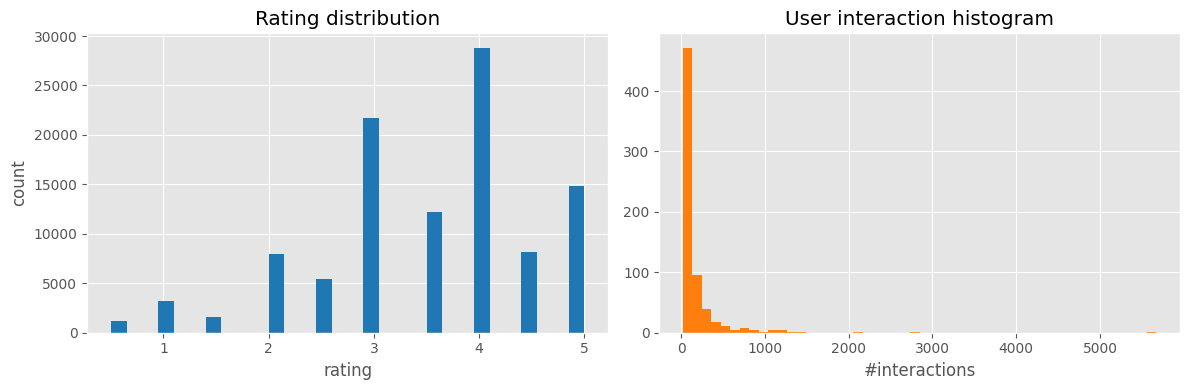

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ratings_df['rating'].hist(bins=30, ax=ax[0], color='#1f77b4')
ax[0].set_title('Rating distribution')
ax[0].set_xlabel('rating')
ax[0].set_ylabel('count')
ax[1].hist(user_counts, bins=50, color='#ff7f0e')
ax[1].set_title('User interaction histogram')
ax[1].set_xlabel('#interactions')
plt.tight_layout()
plt.show()


In [5]:

def build_id_mappings(df: pd.DataFrame):
    user_ids = sorted(df['user'].unique())
    item_ids = sorted(df['item'].unique())
    user2idx = {u: idx for idx, u in enumerate(user_ids)}
    idx2user = {idx: u for u, idx in user2idx.items()}
    item2idx = {i: idx for idx, i in enumerate(item_ids)}
    idx2item = {idx: i for i, idx in item2idx.items()}
    return user2idx, idx2user, item2idx, idx2item


def apply_mappings(df: pd.DataFrame, user2idx, item2idx):
    mapped = df.copy()
    mapped['user_idx'] = mapped['user'].map(user2idx)
    mapped['item_idx'] = mapped['item'].map(item2idx)
    return mapped


def stratified_split(df: pd.DataFrame, val_ratio: float, test_ratio: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_rows, val_rows, test_rows = [], [], []
    for _, user_df in df.groupby('user_idx'):
        shuffled = user_df.sample(frac=1.0, random_state=int(rng.integers(0, 1e9))).reset_index(drop=True)
        total = len(shuffled)
        if total <= 2:
            train_rows.append(shuffled.iloc[:1])
            if total == 2:
                val_rows.append(shuffled.iloc[1:2])
            continue
        val_count = max(1, int(total * val_ratio))
        test_count = max(1, int(total * test_ratio))
        remain = total - val_count - test_count
        if remain <= 0:
            remain = max(1, total - 2)
            val_count = 1
            test_count = 1 if total - remain - val_count >= 1 else 0
        train_rows.append(shuffled.iloc[:remain])
        val_rows.append(shuffled.iloc[remain:remain + val_count])
        if test_count > 0:
            test_rows.append(shuffled.iloc[remain + val_count:remain + val_count + test_count])
    train_df = pd.concat(train_rows).reset_index(drop=True)
    val_df = pd.concat(val_rows).reset_index(drop=True) if val_rows else pd.DataFrame(columns=df.columns)
    test_df = pd.concat(test_rows).reset_index(drop=True) if test_rows else pd.DataFrame(columns=df.columns)
    return train_df, val_df, test_df


In [6]:

user2idx, idx2user, item2idx, idx2item = build_id_mappings(ratings_df)
mapped_df = apply_mappings(ratings_df, user2idx, item2idx)
train_full, val_full, test_full = stratified_split(mapped_df, VAL_RATIO, TEST_RATIO, seed=SEED)
print('Split sizes:', len(train_full), len(val_full), len(test_full))

train_pos = train_full[train_full['label'] == 1].reset_index(drop=True)
val_pos = val_full[val_full['label'] == 1].reset_index(drop=True)
test_pos = test_full[test_full['label'] == 1].reset_index(drop=True)

num_users = len(user2idx)
num_items = len(item2idx)

print('Positives:', len(train_pos), len(val_pos), len(test_pos))


Split sizes: 84687 10226 10226
Positives: 41881 4966 4983


In [7]:

def build_user_pos_dict(df: pd.DataFrame):
    d = defaultdict(set)
    for row in df.itertuples():
        d[row.user_idx].add(row.item_idx)
    return d

train_user_pos = build_user_pos_dict(train_pos)
val_user_pos = build_user_pos_dict(val_pos)
test_user_pos = build_user_pos_dict(test_pos)

item_pop = train_full.groupby('item_idx')['user_idx'].count().to_dict()
max_pop = max(item_pop.values())
hard_negative_pool = sorted(item_pop.keys(), key=lambda x: item_pop[x], reverse=True)[:200]

print('Hard negative pool size:', len(hard_negative_pool))


Hard negative pool size: 200


In [8]:

class PositivePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, item_pop: Dict[int, int], temperature: float = 0.5):
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_idx'].values, dtype=torch.long)
        freqs = np.array([item_pop.get(i, 1) for i in df['item_idx'].values], dtype=np.float32)
        weights = np.power(freqs, -temperature)
        self.weights = torch.tensor(weights, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx: int):
        return self.users[idx], self.items[idx]


def build_dataloader(df: pd.DataFrame, batch_size: int, item_pop: Dict[int, int], temperature: float):
    dataset = PositivePairDataset(df, item_pop, temperature)
    sampler = WeightedRandomSampler(dataset.weights, num_samples=len(dataset), replacement=True)
    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, drop_last=False)
    return loader

train_loader = build_dataloader(train_pos, BATCH_SIZE, item_pop, TAIL_TEMPERATURE)
print('Train steps/epoch:', len(train_loader))


Train steps/epoch: 11


In [9]:

def sample_negative_mix(users: torch.Tensor, user_pos: Dict[int, set], num_items: int,
                        k: int, hard_pool: List[int], hard_ratio: float):
    negatives = []
    hard_size = len(hard_pool)
    for user in users.cpu().tolist():
        user_negs = []
        positives = user_pos.get(user, set())
        for _ in range(k):
            use_hard = random.random() < hard_ratio and hard_size > 0
            while True:
                if use_hard:
                    candidate = hard_pool[random.randint(0, hard_size - 1)]
                else:
                    candidate = random.randint(0, num_items - 1)
                if candidate not in positives:
                    user_negs.append(candidate)
                    break
        negatives.append(user_negs)
    return torch.tensor(negatives, dtype=torch.long, device=users.device)


In [10]:

def build_normalized_adj(num_users: int, num_items: int, interactions: pd.DataFrame, device=DEVICE):
    total_nodes = num_users + num_items
    rows, cols = [], []
    for row in interactions.itertuples():
        u = row.user_idx
        i = row.item_idx + num_users
        rows.extend([u, i])
        cols.extend([i, u])
    indices = torch.tensor([rows, cols], dtype=torch.long)
    values = torch.ones(len(rows), dtype=torch.float32)
    adj = torch.sparse_coo_tensor(indices, values, (total_nodes, total_nodes))
    deg = torch.sparse.sum(adj, dim=1).to_dense()
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    row, col = indices
    norm_values = values * deg_inv_sqrt[row] * deg_inv_sqrt[col]
    norm_adj = torch.sparse_coo_tensor(indices, norm_values, (total_nodes, total_nodes))
    return norm_adj.coalesce().to(device)

norm_adj = build_normalized_adj(num_users, num_items, train_full[['user_idx', 'item_idx']], device=DEVICE)


In [11]:

class LightGCN(nn.Module):
    def __init__(self, num_users: int, num_items: int, embed_dim: int, num_layers: int, norm_adj: torch.Tensor):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embed_dim
        self.num_layers = num_layers
        self.norm_adj = norm_adj
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def propagate(self):
        all_embeddings = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        embeddings = [all_embeddings]
        for _ in range(self.num_layers):
            all_embeddings = torch.sparse.mm(self.norm_adj, all_embeddings)
            embeddings.append(all_embeddings)
        stacked = torch.stack(embeddings, dim=0)
        mean_embeddings = stacked.mean(dim=0)
        users, items = torch.split(mean_embeddings, [self.num_users, self.num_items], dim=0)
        return users, items

    def forward(self, users: torch.Tensor, items: torch.Tensor):
        user_emb, item_emb = self.propagate()
        u = user_emb[users]
        v = item_emb[items]
        return (u * v).sum(dim=1)

    def get_embeddings(self):
        return self.propagate()


In [12]:

def bpr_loss(pos_scores: torch.Tensor, neg_scores: torch.Tensor):
    return -torch.nn.functional.logsigmoid(pos_scores - neg_scores).mean()


def additional_regularization(model: LightGCN, reg_weight: float):
    if reg_weight <= 0:
        return 0.0
    u = model.user_embedding.weight
    v = model.item_embedding.weight
    return reg_weight * (u.pow(2).mean() + v.pow(2).mean())


def train_one_epoch(model, optimizer, loader, user_pos, num_items, hard_pool, hard_ratio):
    model.train()
    total_loss = 0.0
    for users, pos_items in loader:
        users = users.to(DEVICE)
        pos_items = pos_items.to(DEVICE)
        neg_items = sample_negative_mix(users, user_pos, num_items, NEGATIVE_SAMPLE_RATIO, hard_pool, hard_ratio)
        neg_items = neg_items.view(-1)
        repeated_users = users.repeat_interleave(NEGATIVE_SAMPLE_RATIO)

        optimizer.zero_grad()
        pos_scores = model(users, pos_items)
        neg_scores = model(repeated_users, neg_items)
        expanded_pos = pos_scores.repeat_interleave(NEGATIVE_SAMPLE_RATIO)
        loss = bpr_loss(expanded_pos, neg_scores)
        reg = additional_regularization(model, EMBED_REG)
        total = loss + reg
        total.backward()
        optimizer.step()
        total_loss += total.item()
    return total_loss / max(1, len(loader))


In [13]:

def evaluate_ranking(model: nn.Module, train_pos_dict: Dict[int, set], eval_df: pd.DataFrame,
                     num_items: int, k_values=(10, 20)):
    if eval_df.empty:
        return {f'recall@{k}': 0.0 for k in k_values}
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model.get_embeddings()
        score_matrix = torch.matmul(user_emb, item_emb.t()).cpu()
        for user, items in train_pos_dict.items():
            if items:
                score_matrix[user, list(items)] = -1e9
    max_k = max(k_values)
    topk_indices = torch.topk(score_matrix, max_k, dim=1).indices
    metrics = {f'recall@{k}': [] for k in k_values}
    metrics.update({f'ndcg@{k}': [] for k in k_values})
    coverage_items = set()
    for user, group in eval_df.groupby('user_idx'):
        true_items = set(group['item_idx'].tolist())
        ranked = topk_indices[user].tolist()
        coverage_items.update(ranked)
        for k in k_values:
            topk = ranked[:k]
            hits = len(set(topk) & true_items)
            recall = hits / len(true_items) if true_items else 0.0
            dcg = 0.0
            for rank, item in enumerate(topk, start=1):
                if item in true_items:
                    dcg += 1.0 / math.log2(rank + 1)
            ideal = sum(1.0 / math.log2(r + 1) for r in range(1, min(len(true_items), k) + 1))
            ndcg = dcg / ideal if ideal > 0 else 0.0
            metrics[f'recall@{k}'].append(recall)
            metrics[f'ndcg@{k}'].append(ndcg)
    reduced = {m: float(np.mean(vals)) if vals else 0.0 for m, vals in metrics.items()}
    reduced['coverage'] = len(coverage_items) / num_items
    return reduced


In [14]:

lightgcn = LightGCN(num_users, num_items, EMBED_DIM, NUM_LAYERS, norm_adj).to(DEVICE)
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
checkpoint_path = OUTPUT_DIR / 'lightgcn_v2_best.pt'


In [15]:

RUN_TRAINING = True
history = []
best_metric = -1
best_state = None
patience = 0

if RUN_TRAINING:
    for epoch in range(1, EPOCHS + 1):
        epoch_loss = train_one_epoch(lightgcn, optimizer, train_loader, train_user_pos,
                                     num_items, hard_negative_pool, HARD_NEG_RATIO)
        history.append({'epoch': epoch, 'loss': epoch_loss})
        if epoch % EVAL_EVERY == 0:
            val_metrics = evaluate_ranking(lightgcn, train_user_pos, val_pos, num_items)
            msg = ', '.join(f"{k}={v:.4f}" for k, v in val_metrics.items())
            print(f"Epoch {epoch:03d} | loss={epoch_loss:.4f} | {msg}")
            current = val_metrics.get('recall@20', 0.0)
            if current > best_metric:
                best_metric = current
                best_state = copy.deepcopy(lightgcn.state_dict())
                torch.save(best_state, checkpoint_path)
                patience = 0
                print('  → New best checkpoint saved')
            else:
                patience += 1
                if patience >= PATIENCE:
                    print('Early stopping triggered')
                    break
    if best_state is not None:
        lightgcn.load_state_dict(best_state)
else:
    if checkpoint_path.exists():
        lightgcn.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
        print(f'Loaded checkpoint from {checkpoint_path}')
    else:
        print('Training skipped. Set RUN_TRAINING=True to fine-tune LightGCN v2.')


Epoch 005 | loss=0.6860 | recall@10=0.0490, recall@20=0.0823, ndcg@10=0.0407, ndcg@20=0.0512, coverage=0.0265
  → New best checkpoint saved
Epoch 010 | loss=0.6396 | recall@10=0.0467, recall@20=0.0710, ndcg@10=0.0382, ndcg@20=0.0453, coverage=0.0242
Epoch 015 | loss=0.5882 | recall@10=0.0436, recall@20=0.0702, ndcg@10=0.0388, ndcg@20=0.0464, coverage=0.0213
Epoch 020 | loss=0.5509 | recall@10=0.0441, recall@20=0.0717, ndcg@10=0.0410, ndcg@20=0.0482, coverage=0.0222
Epoch 025 | loss=0.5266 | recall@10=0.0424, recall@20=0.0658, ndcg@10=0.0423, ndcg@20=0.0476, coverage=0.0215
Epoch 030 | loss=0.5099 | recall@10=0.0413, recall@20=0.0653, ndcg@10=0.0400, ndcg@20=0.0456, coverage=0.0204
Epoch 035 | loss=0.4992 | recall@10=0.0396, recall@20=0.0679, ndcg@10=0.0386, ndcg@20=0.0456, coverage=0.0202
Early stopping triggered


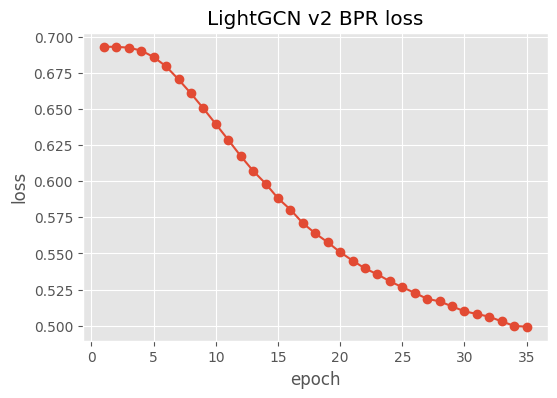

In [16]:

if history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['epoch'] for h in history], [h['loss'] for h in history], marker='o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('LightGCN v2 BPR loss')
    plt.show()


In [17]:

val_metrics = evaluate_ranking(lightgcn, train_user_pos, val_pos, num_items)
test_metrics = evaluate_ranking(lightgcn, train_user_pos, test_pos, num_items)
print('Validation metrics:', json.dumps(val_metrics, indent=2))
print('Test metrics     :', json.dumps(test_metrics, indent=2))


Validation metrics: {
  "recall@10": 0.04896132298480598,
  "recall@20": 0.08227660548078727,
  "ndcg@10": 0.040706596367719484,
  "ndcg@20": 0.05122192953867137,
  "coverage": 0.026547815134192423
}
Test metrics     : {
  "recall@10": 0.04639614337531388,
  "recall@20": 0.07897353926560799,
  "ndcg@10": 0.04003471920218881,
  "ndcg@20": 0.04893501702359657,
  "coverage": 0.02635403546168007
}


In [18]:

def tune_threshold(model: nn.Module, val_pairs: pd.DataFrame, steps: int = 25):
    if val_pairs.empty:
        return 0.5, []
    model.eval()
    users = torch.tensor(val_pairs['user_idx'].values, dtype=torch.long, device=DEVICE)
    items = torch.tensor(val_pairs['item_idx'].values, dtype=torch.long, device=DEVICE)
    labels = val_pairs['label'].values
    with torch.no_grad():
        scores = torch.sigmoid(model(users, items)).cpu().numpy()
    thresholds = np.linspace(0.2, 0.8, steps)
    best = (0.5, -1)
    history = []
    for t in thresholds:
        preds = (scores >= t).astype(int)
        tp = np.logical_and(preds == 1, labels == 1).sum()
        fp = np.logical_and(preds == 1, labels == 0).sum()
        fn = np.logical_and(preds == 0, labels == 1).sum()
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        history.append({'threshold': float(t), 'precision': float(precision), 'recall': float(recall), 'f1': float(f1)})
        if f1 > best[1]:
            best = (float(t), float(f1))
    return best[0], history

best_threshold, threshold_history = tune_threshold(lightgcn, val_full)
print(f'Best threshold on validation pairs: {best_threshold:.3f}')


Best threshold on validation pairs: 0.475


In [19]:

def run_inference(model: nn.Module, user2idx: Dict[int, int], item2idx: Dict[int, int],
                  idx2user: Dict[int, int], idx2item: Dict[int, int], input_df: pd.DataFrame,
                  threshold: float):
    model.eval()
    user_emb, item_emb = model.get_embeddings()
    outputs = []
    recommends = 0
    for row in input_df.itertuples():
        raw_user = getattr(row, 'user')
        raw_item = getattr(row, 'item')
        user_idx = user2idx.get(raw_user)
        item_idx = item2idx.get(raw_item)
        if user_idx is None or item_idx is None:
            score = 0.0
        else:
            score = torch.sigmoid((user_emb[user_idx] * item_emb[item_idx]).sum()).item()
        rec = 'O' if score >= threshold else 'X'
        if rec == 'O':
            recommends += 1
        outputs.append({'user': raw_user, 'item': raw_item, 'score': float(score), 'recommend': rec})
    result_df = pd.DataFrame(outputs)
    print(result_df[['user', 'item', 'recommend']])
    total = len(result_df)
    print(f"Total recommends = {recommends}/{total}, not recommend = {total - recommends}/{total}")
    return result_df

sample_inputs = ratings_df[['user', 'item']].sample(5, random_state=SEED)
_ = run_inference(lightgcn, user2idx, item2idx, idx2user, idx2item, sample_inputs, best_threshold)


   user   item recommend
0   530   1188         O
1   386  26662         O
2   575   4486         O
3   128    588         O
4   668   5384         O
Total recommends = 5/5, not recommend = 0/5


## 다음 단계 & Breakthrough 아이디어
- hard negative 비율, tail temperature, label threshold를 grid search하여 Recall@20 ≥ 0.22 목표
- coverage를 높이기 위해 per-user diversity penalty (top-K unique items) 추가 예정
- LightGCN + NeuMF ensemble (score 평균)도 v2 데이터 파이프라인으로 바로 실험 가능
- inference latency 개선: user embedding caching + candidate pruning 도입 예정
